# Credit Card Customer Churn - Modelling and Evaluation

This notebook is structured to systematically evaluate multiple baseline algorithms in order to identify the model architecture that best fits the churn prediction problem. Once the most suitable approach is selected, the workflow advances through robust validation strategies, systematic model refinement and a final evaluation on a held-out test set, followed by an interpretability analysis.

## 1. Initial Overview

### Data Loading

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

path = "../data/BankChurners_processed.csv"
df = pd.read_csv(path)

df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Avg_Ticket_Size
0,0,45,1,3,2,3,0,39,5,1,3,12691.0,777,1.335,1144,42,1.625,0.061,1,0,0,27.238095
1,0,49,0,5,4,1,0,44,6,1,2,8256.0,864,1.541,1291,33,3.714,0.105,0,1,0,39.121212
2,0,51,1,3,4,4,0,41,4,1,0,3418.0,0,2.594,1887,20,2.333,0.000,1,0,0,94.350000
3,0,40,0,4,2,1,0,34,3,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,0,0,1,58.550000
4,0,40,1,3,1,3,0,21,5,1,0,4716.0,0,2.175,816,28,2.500,0.000,1,0,0,29.142857


## 2. Modelling

### Choosing the Algorithm

Given the business context of customer attrition, we prioritize **tree-based algorithms** over linear models. This decision is driven by both the behavioral nature of the data and the need for operationally actionable insights.

- **Handling Non-Linear Behavioral Effects:**  Churn dynamics exhibit strong non-linear patterns, for example, when transactional frequency can offset low monetary value, while high spending alone does not guarantee retention. Tree-based models naturally capture such conditional and threshold-driven interactions without requiring explicit feature engineering.

- **Robustness to Categorical Encodings:**  Several variables required pragmatic encoding choices, such as mapping "Unknown" categories to sentinel values (-1). Tree-based methods are less sensitive to such encodings, as they rely on threshold-based splits rather than linear or distance-based assumptions.

- **Asymmetric Error Control:**  In churn prediction, false negatives are significantly more costly than false positives. Tree-based models allow explicit control over this trade-off through structural regularization and class weighting, enabling alignment with business priorities.

- **Interpretability and Actionability:**  Beyond predictive performance, tree-based models provide transparent decision rules and feature importance measures, facilitating model validation and supporting downstream business actions.

### Baseline Modeling
#### Decision Tree & Class Imbalance

This section evaluates Decision Trees as a standalone baseline model, assessing whether a simple and interpretable algorithm can adequately capture churn patterns in the presence of class imbalance. To this end, an A/B comparison is conducted between a standard Decision Tree and a class-weighted variant.

As observed in the results, the Standard Model behaves conservatively, maximizing precision and correctly classifying non-churners, but failing to detect over 25% of actual churners, an undesirable outcome for retention. In contrast, the class-weighted model significantly increases sensitivity to the minority class, achieving a Recall of 0.90, but at the cost of substantial noise, with Precision dropping to 0.59.

These observations highlight two key findings: the weighted model clearly captures the churn signal, indicating that class imbalance itself is not the limiting factor, and a single Decision Tree lacks robustness for this problem, exhibiting either excessive conservatism or high variance depending on class weighting. Consequently, over-sampling techniques such as SMOTE are deemed unnecessary and we transition to ensemble-based methods, which are expected to stabilize decision boundaries and improve the precision–recall trade-off without introducing artificial observations.

In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Attrition_Flag'])
y = df['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

common_params = {
    'max_depth': 5,
    'random_state': 42
}

# Reg Tree
dt_reg = DecisionTreeClassifier(**common_params, class_weight=None)
dt_reg.fit(X_train, y_train)
y_pred_reg = dt_reg.predict(X_test)

# Bal Tree
dt_bal = DecisionTreeClassifier(**common_params, class_weight='balanced')
dt_bal.fit(X_train, y_train)
y_pred_bal = dt_bal.predict(X_test)

print("\n Regularized Tree Baseline CR")
print(classification_report(y_test, y_pred_reg))

print("\n Balanced Tree Baseline CR")
print(classification_report(y_test, y_pred_bal))


 Regularized Tree Baseline CR
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1701
           1       0.83      0.73      0.78       325

    accuracy                           0.93      2026
   macro avg       0.89      0.85      0.87      2026
weighted avg       0.93      0.93      0.93      2026


 Balanced Tree Baseline CR
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1701
           1       0.59      0.90      0.71       325

    accuracy                           0.88      2026
   macro avg       0.78      0.89      0.82      2026
weighted avg       0.92      0.88      0.89      2026



---
#### Random Forests

This experiment transitions to a Random Forest ensemble to address the instability observed in a single Decision Tree. By aggregating predictions from multiple decorrelated trees, the objective is to reduce variance and suppress noise while preserving the underlying churn signal.

As shown in the results below, the ensemble strategy effectively reduces false positives, increasing Precision from 0.59 to 0.93. This indicates that when the model flags a customer as at risk, the prediction is highly reliable. However, this conservative behavior comes at the cost of sensitivity, with Recall decreasing to 0.78 as a portion of true churners is no longer detected.

While the Random Forest successfully stabilizes decision boundaries and mitigates noise, it overcorrects by prioritizing certainty over coverage, failing to identify approximately 22% of actual churners. Although further hyperparameter tuning could potentially rebalance this trade-off, a more efficient next step is to evaluate a fundamentally different learning paradigm. This motivates the transition to boosting-based algorithms, starting with XGBoost.

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Baseline CR")
print(classification_report(y_test, y_pred_rf))

Random Forest Baseline CR
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1701
           1       0.93      0.78      0.85       325

    accuracy                           0.96      2026
   macro avg       0.95      0.89      0.91      2026
weighted avg       0.96      0.96      0.96      2026



---
#### XGBoost

To address the conservative recall limitations observed in the Random Forest model, we transition to a Gradient Boosting architecture using XGBoost. Unlike bagging-based ensembles, boosting iteratively emphasizes hard-to-classify instances, allowing the model to explicitly learn from previously missed churners while maintaining control over false positives.

The baseline results below strongly confirm the suitability of this approach for the underlying structure of the dataset. The most notable improvement is the substantial increase in Recall, rising from 0.78 to 0.89, which indicates that the boosting mechanism successfully captured patterns associated with approximately 11% of churners that the Random Forest failed to identify. Importantly, this gain in sensitivity was achieved without a meaningful degradation in Precision, which remained high at 0.92.

However, since these results are derived from a single train–test split, they may not fully reflect the model’s generalization capability. Consequently, the next step is to validate the robustness and stability of this performance through stratified cross-validation before proceeding to any hyperparameter optimization.

In [5]:
import numpy as np
from xgboost import XGBClassifier

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb = XGBClassifier(scale_pos_weight=ratio, random_state=42, n_jobs=-1)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Baseline CR")
print(classification_report(y_test, y_pred_xgb))

XGBoost Baseline CR
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.92      0.89      0.91       325

    accuracy                           0.97      2026
   macro avg       0.95      0.94      0.95      2026
weighted avg       0.97      0.97      0.97      2026



##### Cross-Validation

The cross-validation results confirm that the strong performance observed previously is not an artifact of a favorable split. Across folds, the model consistently maintains a high balance between sensitivity and precision, achieving a mean Recall of 0.91 and a mean Precision of 0.90, with low variance across folds. This stability indicates that the boosting architecture is robust to fluctuations in the training data and reliably captures the churn signal.

The resulting mean F1-score of 0.91 further reinforces XGBoost as a strong candidate for this task, outperforming earlier baselines not only in peak performance but also in consistency. With generalization now empirically validated, the model is well-positioned for controlled refinement through hyperparameter optimization, aiming to further improve the precision–recall trade-off without compromising robustness.

In [6]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1'}

cv_results_xgb = cross_validate(xgb, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

print("XGBoost Baseline - CV Metrics")
print(f"Mean F1:        {cv_results_xgb['test_f1'].mean():.4f} (+/- {cv_results_xgb['test_f1'].std():.4f})")
print(f"Mean Recall:    {cv_results_xgb['test_recall'].mean():.4f} (+/- {cv_results_xgb['test_recall'].std():.4f})")
print(f"Mean Precision: {cv_results_xgb['test_precision'].mean():.4f} (+/- {cv_results_xgb['test_precision'].std():.4f})")

XGBoost Baseline - CV Metrics
Mean F1:        0.9073 (+/- 0.0132)
Mean Recall:    0.9101 (+/- 0.0183)
Mean Precision: 0.9049 (+/- 0.0188)


##### Hyperparameter Tuning with Optuna

To refine the XGBoost baseline and maximize the F1-score, a Bayesian Optimization strategy was implemented using Optuna. The hyperparameter search space was deliberately designed to mitigate class imbalance and reduce overfitting risks by:

- constraining `max_depth` to moderate values to prevent overly deep trees that could memorize noise, while using `min_child_weight` and `gamma` to enforce more conservative and meaningful splits.

- optimizing the trade-off between `learning_rate` and `n_estimators` to allow the model to learn more gradually and reduce the risk of overfitting.

- tuning `subsample` and `colsample_bytree` to introduce controlled stochasticity, encouraging the model to generalize across different data and feature subsets.

- introducing `max_delta_step` to stabilize weight updates under severe class imbalance.

The Bayesian optimization process led to a consistent improvement over the baseline XGBoost model, achieving a best cross-validated F1-score of 0.9133 ± 0.0097 when compared to 0.9073 ± 0.0132 obtained with the untuned configuration. This gain indicates a more balanced trade-off between precision and recall, which is particularly critical in the churn prediction setting under strong class imbalance. The optimized model converged to a moderately complex tree structure combined with controlled learning dynamics and stochastic sampling, suggesting that the performance improvement stems from better generalization rather than increased model capacity. 

In [7]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 2),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),

        # Fixed Params
        'scale_pos_weight': ratio,
        'random_state': 42,
        'n_jobs': -1,
    }
    
    xgb_opt = XGBClassifier(**param_grid)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(xgb_opt, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

    std_score = scores.std()
    trial.set_user_attr("std", std_score)
    
    return scores.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_std = study.best_trial.user_attrs['std']

print("\nOptimization Results")
print(f"Best F1-Score: {study.best_value:.4f} +/- {best_std:.4f}")
print("\nBest Hyperparameters:")
print(study.best_params)

  0%|          | 0/30 [00:00<?, ?it/s]


Optimization Results
Best F1-Score: 0.9133 +/- 0.0097

Best Hyperparameters:
{'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.07542741196521725, 'n_estimators': 556, 'subsample': 0.6731645877024434, 'colsample_bytree': 0.696702712715432, 'gamma': 0.230351235686711, 'max_delta_step': 10}


##### Final Model Evaluation

After completing hyperparameter tuning, the optimized XGBoost model was retrained on the full training dataset and evaluated on a hold-out test set to assess its generalization performance. The model achieved an F1-score of 0.92 on the test data, slightly outperforming the cross-validated score of 0.9133, indicating strong alignment between validation and unseen data and suggesting effective control over overfitting.

From a business perspective, the model delivers a well-balanced performance. A precision of 0.93 ensures that retention efforts are focused on customers genuinely at risk (reducing unnecessary interventions), while a recall of 0.90 captures the majority of churners, providing a robust safety margin for proactive action. This combination establishes a reliable foundation for deployment and motivates a deeper interpretability analysis to uncover the key drivers behind the model’s predictions.

Tuned XGBoost CR
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.93      0.90      0.92       325

    accuracy                           0.97      2026
   macro avg       0.96      0.94      0.95      2026
weighted avg       0.97      0.97      0.97      2026



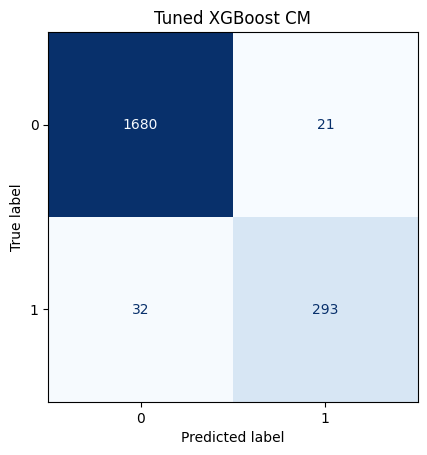

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

xgb_tuned = XGBClassifier(**study.best_params, scale_pos_weight=ratio, random_state=42, n_jobs=-1,)

xgb_tuned.fit(X_train, y_train)
y_pred_final = xgb_tuned.predict(X_test)

print("Tuned XGBoost CR")
print(classification_report(y_test, y_pred_final))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, cmap='Blues', colorbar=False)
plt.title("Tuned XGBoost CM")
plt.show()

##### Model Interpretability with SHAP

To move beyond predictive performance and extract actionable insights, SHAP values were computed on a representative subsample (n=100) to optimize processing efficiency. This approach provides a transparent interpretation, revealing both the direction and magnitude of each feature’s impact on churn probability.

Analyzing the top three features, transaction frequency (`Total_Trans_Ct`) emerges as the dominant driver of retention. High transaction activity is strongly associated with non-churn behavior, whereas low frequency is the clearest indicator of risk. Secondly, higher revolving balances (`Total_Revolving_Bal`) are consistently linked to lower churn, suggesting that financial engagement creates a barrier to exit. Finally, the engineered feature `Avg_Ticket_Size` reveals that customers with higher average transaction values are more likely to churn, indicating that habit is a stronger retention signal than transaction magnitude.

Overall, the SHAP results corroborate the patterns identified during EDA, providing a rigorous validation of these relationships. By translating predictive behavior into interpretable explanations, this analysis strengthens confidence in the model and offers clear guidance for data-driven retention strategies.

PermutationExplainer explainer: 2027it [02:19, 13.91it/s]                       


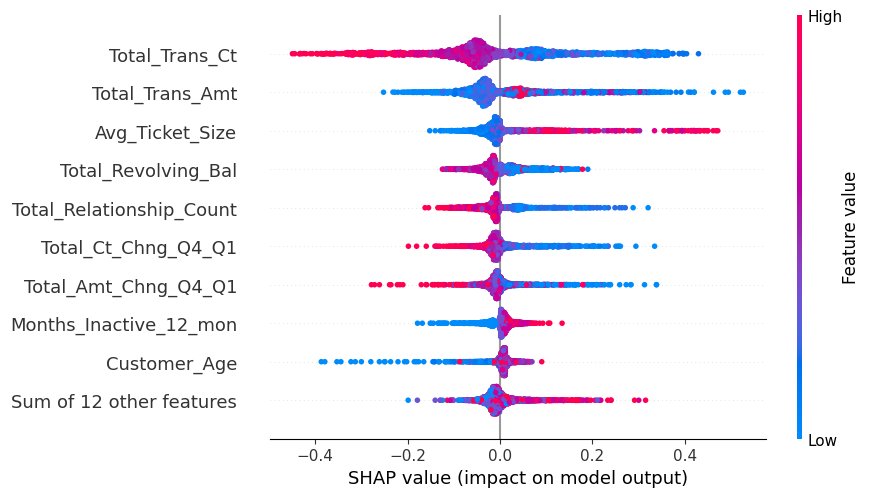

In [12]:
import shap

X_train_summary = shap.utils.sample(X_train, 100, random_state=42) 

explainer = shap.Explainer(xgb_tuned.predict_proba, X_train_summary)

shap_values = explainer(X_test)
shap_values_churn = shap_values[..., 1]

shap.plots.beeswarm(shap_values_churn)

## 3. Saving the Model

To conclude, we serialize the complete artifact containing the model, feature names, and training means. This structure enables the deployment app to automatically impute missing values using training averages, ensuring robust inference.

In [10]:
import pickle

defaults = X_train.mean()

artifact = {
    "model": xgb_tuned,
    "columns": X_train.columns,
    "defaults": defaults
}

with open("../model/churn_model.pickle", "wb") as f:
    pickle.dump(artifact, f)


---
<center>
  <div style="font-size: 0.85em; color: #555;">
    This notebook was developed as part of a personal data science portfolio project focused on customer churn prediction.</br>
    Author: Pedro Siqueira.</br>
    <a href="https://www.linkedin.com/in/phenriquels/" target="_blank">LinkedIn</a> ·
    <a href="https://github.com/phenriquels01" target="_blank">GitHub</a>
  </div>
</center>
